# Step 3. Train the model (LSTM)

Using the data created from Step 1, here we are going to build a simple benchmark model (simple neural network) to evaluate the stock return predictability.

We find the model in Step 2 is barely the same as Random walk. Let's try whether a more complicated model, LSTM can be helpful.

In [2]:
# data 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

In [3]:
# sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role

In [4]:
# SageMaker session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# default S3 bucket
bucket = sagemaker_session.default_bucket()

In [5]:
data_dir = 'data' # the folder we will use for storing data
train_name = 'train.csv'

In [6]:
# specify where to upload in S3
prefix = 'stock-price-predictor'

# upload to S3
test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

print(train_location)
print(test_location)

s3://sagemaker-ap-northeast-1-165829362107/stock-price-predictor/train.csv
s3://sagemaker-ap-northeast-1-165829362107/stock-price-predictor/test.csv


In [7]:
!pygmentize source_lstm/model.py

import torch
import torch.nn as nn
import torch.nn.functional as F

# Here we define our model as a class
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim, feature_dim, hidden_dim, output_dim):
        super().__init__()

        self.feature_dim = feature_dim
        self.fc1 = nn.Linear(input_dim, self.feature_dim)

        self.hidden_layer_size = hidden_dim
        self.lstm = nn.LSTM(self.feature_dim, hidden_dim)
        self.hidden_cell = (torch.zeros(1, 1, self.hidden_layer_size),
                            torch.zeros(1, 1, self.hidden_layer_size))

        self.drop = nn.Dropout(0.1)
        self.fc2 = nn.Linear(hidden_dim, output_dim)


    def forward(self, input_seq):

        out = input_seq.view(len(input_seq), 1, -1)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.drop(out)

        out, self.hidden_cell = self.lstm(out, self.hidden_cell)
        out = out.view(len(out), -1)
        out = self.drop(out)

        predictions = self.f

In [8]:
!pygmentize source_lstm/train.py

from __future__ import print_function  # future proof
import argparse
import sys
import os
import json

import pandas as pd

# pytorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data

# import model
from model import SimpleLSTM

def model_fn(model_dir):
    print("Loading model.")

    # First, load the parameters used to create the model.
    model_info = {}
    model_info_path = os.path.join(model_dir, 'model_info.pth')
    with open(model_info_path, 'rb') as f:
        model_info = torch.load(f)

    print("model_info: {}".format(model_info))

    # Determine the device and construct the model.
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SimpleLSTM(model_info['input_dim'],
                       model_info['feature_dim'],
                       model_info['hidden_dim'],
                       model_info['output_dim'])

    # Load the stored model parameters.
    model_path = os.path.join(model_dir, 'mod

## Train the Model

In [9]:
# import a PyTorch wrapper
from sagemaker.pytorch import PyTorch

# specify an output path
# prefix is specified above
output_path = 's3://{}/{}'.format(bucket, prefix)

# instantiate a pytorch estimator
estimator = PyTorch(entry_point='train.py',
                    source_dir='source_lstm', # this should be just "source" for your code
                    role=role,
                    framework_version='1.3.1',
                    train_instance_count=1,
                    train_instance_type='ml.m4.xlarge',
                    output_path=output_path,
                    sagemaker_session=sagemaker_session,
                    hyperparameters={
                        'input_dim': 46,  # num of features
                        'hidden_dim': 3,
                        'feature_dim': 5,
                        'output_dim': 1,
                        'epochs': 5, # could change to higher
                        'validation_split': 0.1,
                    })

In [10]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')

In [11]:
# First, make sure to import the relevant objects used to construct the tuner
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_tuner = HyperparameterTuner(estimator = estimator, # The estimator object to use as the basis for the training jobs.
                                           objective_metric_name = 'validation:rmse', # The metric used to compare trained models.
                                           metric_definitions=[{'Name': 'validation:rmse',
                                                                'Regex': 'validation:rmse=(-?[\d.]+(?:e[+-]?\d+)?)'}],
                                           objective_type = 'Minimize', # Whether we wish to minimize or maximize the metric.
                                           max_jobs = 30, # The total number of models to train
                                           max_parallel_jobs = 6, # The number of models to train in parallel
                                           hyperparameter_ranges = {
                                               'hidden_dim': IntegerParameter(5, 25),
                                               'feature_dim': IntegerParameter(5, 25),
                                               'validation_split': ContinuousParameter(0.10, 0.25),
                                               'epochs': IntegerParameter(5, 15),
                                           },
                                          )

In [11]:
hyperparameter_tuner.fit({'train': s3_input_train})

In [ ]:
hyperparameter_tuner.wait()

.........

In [14]:
hyperparameter_tuner = hyperparameter_tuner.attach("pytorch-training-200224-1152")

In [15]:
tuner_res = hyperparameter_tuner.analytics()
tuner_res.dataframe()

,FinalObjectiveValue,TrainingElapsedTimeSeconds,TrainingEndTime,TrainingJobName,TrainingJobStatus,TrainingStartTime,epochs,feature_dim,hidden_dim,validation_split
0,2.322859e-07,5476.0,2020-02-24 18:02:00+00:00,pytorch-training-200224-1152-030-0adc9183,Completed,2020-02-24 16:30:44+00:00,15.0,5.0,11.0,0.210592
1,5.840507e-07,4469.0,2020-02-24 17:27:50+00:00,pytorch-training-200224-1152-029-4418cf66,Completed,2020-02-24 16:13:21+00:00,14.0,6.0,7.0,0.245905
2,2.898891e-07,5353.0,2020-02-24 17:42:08+00:00,pytorch-training-200224-1152-028-47d403ca,Completed,2020-02-24 16:12:55+00:00,15.0,6.0,22.0,0.248733
3,2.899554e-07,5303.0,2020-02-24 17:33:49+00:00,pytorch-training-200224-1152-027-7ed731c4,Completed,2020-02-24 16:05:26+00:00,15.0,6.0,22.0,0.247763
4,1.063517e-06,845.0,2020-02-24 16:10:30+00:00,pytorch-training-200224-1152-026-b8c0768b,Completed,2020-02-24 15:56:25+00:00,6.0,17.0,11.0,0.230480
5,5.864266e-07,4459.0,2020-02-24 17:09:43+00:00,pytorch-training-200224-1152-025-d1f1aa60,Completed,2020-02-24 15:55:24+00:00,14.0,6.0,7.0,0.247405
6,3.139430e-07,4466.0,2020-02-24 16:27:12+00:00,pytorch-training-200224-1152-024-293b842e,Completed,2020-02-24 15:12:46+00:00,14.0,25.0,11.0,0.244074
7,2.018885e-07,5564.0,2020-02-24 16:37:39+00:00,pytorch-training-200224-1152-023-68aee74f,Completed,2020-02-24 15:04:55+00:00,15.0,14.0,23.0,0.236529
8,3.117540e-07,4456.0,2020-02-24 16:11:01+00:00,pytorch-training-200224-1152-022-861a8289,Completed,2020-02-24 14:56:45+00:00,14.0,25.0,11.0,0.245574
9,1.954144e-07,4581.0,2020-02-24 16:02:52+00:00,pytorch-training-200224-1152-021-3d4c0e03,Completed,2020-02-24 14:46:31+00:00,14.0,17.0,19.0,0.243180


In [16]:
tuner_res.export_csv("data/hyperparameter-tuning.csv")

In [17]:
estimator_attached = sagemaker.estimator.Estimator.attach(hyperparameter_tuner.best_training_job())

2020-02-24 16:02:52 Starting - Preparing the instances for training
2020-02-24 16:02:52 Downloading - Downloading input data
2020-02-24 16:02:52 Training - Training image download completed. Training in progress.
2020-02-24 16:02:52 Uploading - Uploading generated training model
2020-02-24 16:02:52 Completed - Training job completedbash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-02-24 14:47:18,708 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-02-24 14:47:18,709 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
2020-02-24 14:47:18,712 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-02-24 14:47:18,724 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-02-24 14:47:20,149 sagemaker_pytorch_container.training IN

In [18]:
estimator_attached.set_hyperparameters(validation_split=0)
estimator_attached.hyperparameters()

{'_tuning_objective_metric': 'validation:rmse',
 'epochs': '14',
 'feature_dim': '17',
 'hidden_dim': '19',
 'input_dim': '46',
 'output_dim': '1',
 'sagemaker_container_log_level': '20',
 'sagemaker_enable_cloudwatch_metrics': 'false',
 'sagemaker_estimator_class_name': '"PyTorch"',
 'sagemaker_estimator_module': '"sagemaker.pytorch.estimator"',
 'sagemaker_job_name': '"pytorch-training-2020-02-24-11-52-00-413"',
 'sagemaker_program': '"train.py"',
 'sagemaker_region': '"ap-northeast-1"',
 'sagemaker_submit_directory': '"s3://sagemaker-ap-northeast-1-165829362107/pytorch-training-2020-02-24-11-52-00-413/source/sourcedir.tar.gz"',
 'validation_split': 0}

In [ ]:
# Fit the validation set into the model to get the final model

estimator_attached.fit({'train': s3_input_train})

2020-02-25 02:44:25 Starting - Starting the training job...
2020-02-25 02:44:26 Starting - Launching requested ML instances......
2020-02-25 02:45:31 Starting - Preparing the instances for training...
2020-02-25 02:46:16 Downloading - Downloading input data...
2020-02-25 02:46:51 Training - Downloading the training image..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2020-02-25 02:47:07,335 sagemaker-containers INFO     Imported framework sagemaker_pytorch_container.training
2020-02-25 02:47:07,336 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
2020-02-25 02:47:07,338 sagemaker-containers INFO     No GPUs detected (normal if no gpus installed)
2020-02-25 02:47:07,350 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2020-02-25 02:47:07,351 sagemaker_pytorch_container.training INFO     Inv

## Deploy the Model

In [50]:
# importing PyTorchModel
from sagemaker.pytorch import PyTorchModel

# Create a model from the trained estimator data
# And point to the prediction script
model = PyTorchModel(model_data=estimator_attached.model_data,
                     role = role,
                     framework_version='1.3.1',
                     entry_point='predict.py',
                     source_dir='source_lstm')

In [51]:
%%time
# deploy and create a predictor
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

-------------!CPU times: user 489 ms, sys: 15.5 ms, total: 504 ms
Wall time: 6min 33s


In [52]:
df_test = pd.read_csv("data/test.csv", header=None, index_col=False)

df = pd.read_csv("data/data.csv", index_col=0)
df.index = pd.to_datetime(df.index)
split = int(df.shape[0] * 0.95)

df_test.index = df[split:].index

In [53]:
input_data = np.array(df_test)

X_test = input_data[:, 1:]
y_test = input_data[:, 0]

y_pred = predictor.predict(X_test)

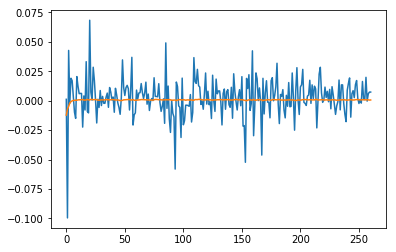

In [54]:
plt.figure()
plt.plot(y_test)
plt.plot(y_pred)
plt.show()

In [55]:
y_pred = y_pred.reshape(y_pred.shape[0])
y_test = y_test.reshape(y_pred.shape[0])

accuracy = ( np.logical_or( np.logical_and(y_pred >= 0, y_test >= 0),
                            np.logical_and(y_pred < 0, y_test < 0) ) ).sum() / len(y_test)
print("Accuracy =", accuracy)

Accuracy = 0.5747126436781609


In [60]:
mse = np.sum((y_pred - y_test)**2) / len(y_pred)
rmse = np.sqrt(mse)
rmse

0.016237079092368368

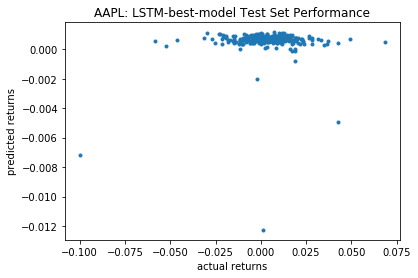

In [57]:
plt.figure()
plt.title("AAPL: LSTM-best-model Test Set Performance")
plt.xlabel("actual returns")
plt.ylabel("predicted returns")
plt.plot(y_test, y_pred, ls=' ', marker='.')
plt.savefig("data/figs/LSTM-best-model-scatterplot.png", dpi=600)

In [58]:
# Visualization # 
price = 155.21400451660156

price_real = price * pd.Series(1 + y_test).cumprod()
price_real = np.append(np.array([price]), price_real)

price_pred = price_real[:-1] * pd.Series(1 + y_pred)
price_pred = np.append(np.array([price]), price_pred)

price_pred_no_adjust = price * pd.Series(1 + y_pred).cumprod()
price_pred_no_adjust = np.append(np.array([price]), price_pred_no_adjust)

price_real = pd.Series(price_real[:-1], index=df_test.index)
price_pred = pd.Series(price_pred[:-1], index=df_test.index)
price_pred_no_adjust = pd.Series(price_pred_no_adjust[:-1], index=df_test.index)

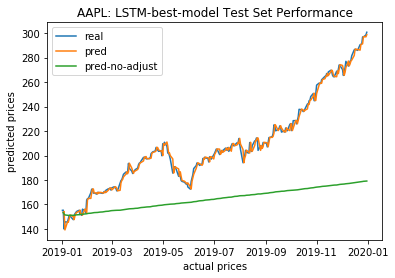

In [59]:
# Analytics # 

plt.figure()
plt.title("AAPL: LSTM-best-model Test Set Performance")
plt.xlabel("actual prices")
plt.ylabel("predicted prices")
plt.plot(df_test.index, price_real, label='real')
plt.plot(df_test.index[1:], price_pred[1:], label='pred')
plt.plot(df_test.index[1:], price_pred_no_adjust[1:], label='pred-no-adjust')
plt.legend()
plt.savefig("data/figs/LSTM-best-model-test-set.png", dpi=600)

**Conclusion:**

LSTM is merely slightly better than the Simple Net. Even LSTM with hyperparameters tuned are no more better. The rmse of the test set only increased from 1.630% to 1.624%. The accuracy is around 57.47%.

Compared with Simple Net model, the model learnt slightly from the initial crash down and learnt the subsequent fevering and predict that the prices should be smoothly increasing. The fact is like our forecasts. The model is good.

However, the simple Net in this case, is no worse than the complex LSTM.

In [62]:
# Accepts a predictor endpoint as input
# And deletes the endpoint by name
def delete_endpoint(predictor):
        try:
            boto3.client('sagemaker').delete_endpoint(EndpointName=predictor.endpoint)
            print('Deleted {}'.format(predictor.endpoint))
        except:
            print('Already deleted: {}'.format(predictor.endpoint))

In [63]:
# delete the predictor endpoint 
delete_endpoint(predictor)

Deleted pytorch-inference-2020-02-24-10-06-31-838
